In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf
from os.path import expanduser, join, abspath
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.types import StructField
import numpy as np
import pandas as pd
import matplotlib.dates as mdate
from pyspark.sql.functions import udf, col

In [2]:
warehouse_location = abspath('/user/hive/warehouse')

In [3]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .master("spark://app-13:7077") \
    .getOrCreate()
df = spark.read.format("CSV").option("header","true").\
option("timestampFormat ","yyyy-MM-dd'T'HH").\
schema("user_id int,item_id int,behavior_type int,user_geohash string,item_category int,create_time string").\
load("/user/hive/warehouse/test.db/tianchi/tianchi_mobile_recommend_train_user.csv") 
df.createOrReplaceTempView("taobao")

In [11]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [14]:
sqlDF = spark.sql("SELECT date(to_timestamp(create_time)) as create_day,count(distinct user_id) as pbcfd,count(behavior_type) as buy FROM taobao where behavior_type=4 group by date(to_timestamp(create_time)) order by date(to_timestamp(create_time))")

In [15]:
sqlDF.cache()

DataFrame[create_day: date, pbcfd: bigint, buy: bigint]

In [17]:
sqlDF.createOrReplaceTempView("pbcf")
sqlPandasDF = spark.sql("select cast(create_day as string)as create_day, pbcfd, buy from pbcf")
pbcfPandasDF = sqlPandasDF.toPandas()

/hadoop/Anaconda/Anaconda3-2018.12-Linux-x86_64/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


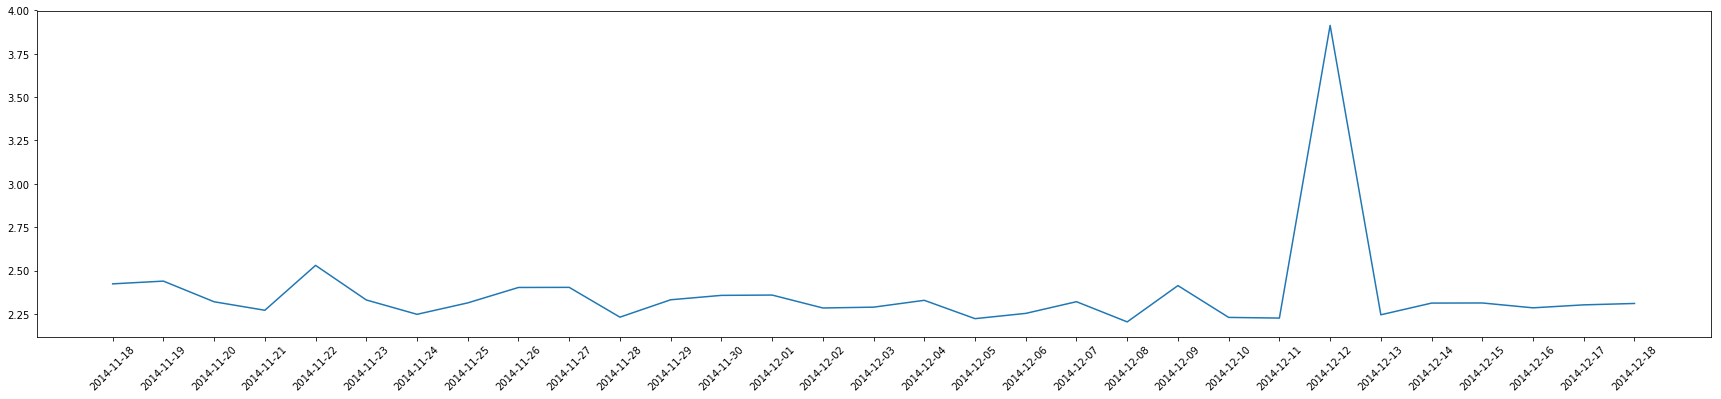

In [19]:
fig=plt.figure(figsize=(30,6))
ax=fig.add_subplot(1,1,1)
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
date_series=pd.date_range(pbcfPandasDF['create_day'][0],pbcfPandasDF['create_day'][30],freq='D')
plt.xticks(date_series,rotation=45)
# axis=0: row; axis=1: col
pbcfPandasDF['perBuy'] = pbcfPandasDF['buy'] / pbcfPandasDF['pbcfd']
ax.plot(date_series,pbcfPandasDF.drop(['pbcfd','buy'], axis=1).set_index('create_day'))
plt.show()